Downloading the dataset

In [3]:
import json
import os
import urllib

url = "/kaggle/input/instruction-dataset-25/seperempat_dataset.json"

# Try to load the JSON file as a list of objects
try:
  with open(url, "r") as file:
    data = json.load(file)

except json.JSONDecodeError:
  # If loading as a single object fails, try loading as a list of objects
  with open(url, "r") as file:
    data = []
    for line in file:
      try:
        data.append(json.loads(line))
      except json.JSONDecodeError as e:
        print(f"Skipping invalid line: {line.strip()} due to error: {e}")

print("Number of entries:", len(data))

Number of entries: 12898


In [4]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Mengingat teks berikut, klasifikasikan emosi yang diungkapkan oleh teks tersebut.', 'input': 'Saya tidak percaya saya gagal dalam ujian.', 'output': 'Ketidakpercayaan dan kekecewaan.'}


## the prompt formatting function

In [5]:
def format_input(entry):
    instruction_text = (
        f"Berikut adalah instruksi yang menjelaskan sebuah tugas."
        f"Silakan tulis respons yang sesuai untuk menyelesaikan permintaan ini."
        f"\n\n### Instruksi:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Masukan:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Berikut adalah instruksi yang menjelaskan sebuah tugas.Silakan tulis respons yang sesuai untuk menyelesaikan permintaan ini.

### Instruksi:
Mengingat teks berikut, klasifikasikan emosi yang diungkapkan oleh teks tersebut.

### Masukan:
Saya tidak percaya saya gagal dalam ujian.

### Response:
Ketidakpercayaan dan kekecewaan.


In [7]:
model_input = format_input(data[773])

desired_response = f"\n\n### Response:\n{data[773]['output']}"

print(model_input + desired_response)

Berikut adalah instruksi yang menjelaskan sebuah tugas.Silakan tulis respons yang sesuai untuk menyelesaikan permintaan ini.

### Instruksi:
Identifikasi hewan berikut.

### Masukan:
Ia memiliki bulu yang tebal, ekor yang panjang, dan telinga yang runcing.

### Response:
Berdasarkan informasi yang diberikan, hewan yang dijelaskan bisa berupa kucing, rubah, atau bahkan mungkin lynx. Informasi lebih lanjut akan diperlukan untuk mengidentifikasi hewan tertentu secara akurat.


## Partitioning the dataset

In [8]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 10963
Validation set length: 646
Test set length: 1289


## Implementing an instruction dataset class

In [9]:
import torch
from torch.utils.data import Dataset
class InstructionDataset(Dataset):
    
  def __init__(self, data, tokenizer):
    self.data = data
    self.encoded_texts = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(tokenizer.encode(full_text))

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

In [10]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.7 MB/s eta 0:00:00 0:00:01


In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
def custom_collate_draft_1(
  batch,
  pad_token_id=50256,
  device="cpu"
):

  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst = []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

    inputs = torch.tensor(padded[:-1])
    inputs_lst.append(inputs)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]


batch = (
  inputs_1,
  inputs_2,
  inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [14]:
def custom_collate_draft_2(
  batch,
  pad_token_id=50256,
  device="cpu"
):

  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst, targets_lst = [], []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
    inputs = torch.tensor(padded[:-1]) #A
    targets = torch.tensor(padded[1:]) #B
    inputs_lst.append(inputs)
    targets_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)

print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


## 7.5 Implementing a custom batch collate function

In [15]:
def custom_collate_fn(

  batch,
  pad_token_id=50256,
  ignore_index=-100,
  allowed_max_length=None,
  device="cpu"
):

  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst, targets_lst = [], []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    # Pad sequences to max_length
    padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
    inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
    targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets

    mask = targets == pad_token_id #A
    indices = torch.nonzero(mask).squeeze() #A
    if indices.numel() > 1: #A
      targets[indices[1:]] = ignore_index #A
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length] #B
      targets = targets[:allowed_max_length] #B

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor, targets_tensor

inputs, targets = custom_collate_fn(batch)

print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
logits_1 = torch.tensor(
  [[-1.0, 1.0],
  [-0.5, 1.5]] # predictions for 2nd token
)

targets_1 = torch.tensor([0, 1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)

print(loss_1)

tensor(1.1269)


In [17]:
logits_2 = torch.tensor(
  [[-1.0, 1.0],
  [-0.5, 1.5],
  [-0.5, 1.5]] #A
)

targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)

print(loss_2)

tensor(0.7936)


In [18]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)

print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if torch.backends.mps.is_available(): #A
# device = torch.device("mps")" #A

print("Device:", device)

Device: cuda


In [20]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device,
allowed_max_length=1024)

## Initializing the data loaders

In [21]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 4

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
  train_dataset,
  batch_size=batch_size,
  collate_fn=customized_collate_fn,
  shuffle=True,
  drop_last=True,
  num_workers=num_workers
)



val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
  val_dataset,
  batch_size=batch_size,
  collate_fn=customized_collate_fn,
  shuffle=False,
  drop_last=False,
  num_workers=num_workers
)



test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
  test_dataset,
  batch_size=batch_size,
  collate_fn=customized_collate_fn,
  shuffle=False,
  drop_last=False,
  num_workers=num_workers
)

In [22]:
print("Train loader:")

for inputs, targets in train_loader:
  print(inputs.shape, targets.shape)

Train loader:
torch.Size([4, 780]) torch.Size([4, 780])
torch.Size([4, 516]) torch.Size([4, 516])
torch.Size([4, 1024]) torch.Size([4, 1024])
torch.Size([4, 518]) torch.Size([4, 518])
torch.Size([4, 924]) torch.Size([4, 924])
torch.Size([4, 1006]) torch.Size([4, 1006])
torch.Size([4, 809]) torch.Size([4, 809])
torch.Size([4, 1024]) torch.Size([4, 1024])
torch.Size([4, 976]) torch.Size([4, 976])
torch.Size([4, 913]) torch.Size([4, 913])
torch.Size([4, 806]) torch.Size([4, 806])
torch.Size([4, 414]) torch.Size([4, 414])
torch.Size([4, 784]) torch.Size([4, 784])
torch.Size([4, 878]) torch.Size([4, 878])
torch.Size([4, 480]) torch.Size([4, 480])
torch.Size([4, 474]) torch.Size([4, 474])
torch.Size([4, 704]) torch.Size([4, 704])
torch.Size([4, 238]) torch.Size([4, 238])
torch.Size([4, 596]) torch.Size([4, 596])
torch.Size([4, 625]) torch.Size([4, 625])
torch.Size([4, 842]) torch.Size([4, 842])
torch.Size([4, 418]) torch.Size([4, 418])
torch.Size([4, 525]) torch.Size([4, 525])
torch.Size([4,

## Loading the pretrained model

In [23]:
import torch.nn as nn
import numpy as np

In [24]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)

#Mengambil nama file dari URL
filename = url.split('/')[-1]

#Mendownload file dan menyimpannya ke dalam direktori lokal
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7d527cac6ef0>)

In [25]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift



class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx) #A|

    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
      d_in=cfg["emb_dim"],
      d_out=cfg["emb_dim"],
      context_length=cfg["context_length"],
      num_heads=cfg["n_heads"],
      dropout=cfg["drop_rate"],
      qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x): #A
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # Add the original input back
    shortcut = x #B
    x = self.norm2(x)
    x = self.ff(x) # Call the feedforward layer
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x # Return the output of the block

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out,
    context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads #A
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) #B
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )



  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x) #C
    queries = self.W_query(x) #C
    values = self.W_value(x) #C
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) #D
    values = values.view(b, num_tokens, self.num_heads, self.head_dim) #D
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) #D
    keys = keys.transpose(1, 2) #E
    queries = queries.transpose(1, 2) #E
    values = values.transpose(1, 2) #E
    attn_scores = queries @ keys.transpose(2, 3) #F
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens] #G
    attn_scores.masked_fill_(mask_bool, -torch.inf) #H
    attn_weights = torch.softmax(
    attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2) #I
    #J

    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec) #K
    return context_vec


class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh( torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(

    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),

    GELU(),

    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),

    )



  def forward(self, x):

    return self.layers(x)



def load_weights_into_gpt(gpt, params):

    #Memasukkan embedding posisi (positional embeddings) dan embedding token ke dalam model

    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])

    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])



    #Iterasi melalui setiap block transformer dalam model GPT

    for b in range(len(params["blocks"])):

        #Memisahkan query, key, dan value dari parameter pre-trained

        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)



        #Mengatur bobot query, key, dan value ke layer transformer

        gpt.trf_blocks[b].att.W_query.weight = assign(

            gpt.trf_blocks[b].att.W_query.weight, q_w.T)

        gpt.trf_blocks[b].att.W_key.weight = assign(

            gpt.trf_blocks[b].att.W_key.weight, k_w.T)

        gpt.trf_blocks[b].att.W_value.weight = assign(

            gpt.trf_blocks[b].att.W_value.weight, v_w.T)



        #Mengatur bias untuk query, key, dan value

        q_b, k_b, v_b = np.split(

            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

        gpt.trf_blocks[b].att.W_query.bias = assign(

            gpt.trf_blocks[b].att.W_query.bias, q_b)

        gpt.trf_blocks[b].att.W_key.bias = assign(

            gpt.trf_blocks[b].att.W_key.bias, k_b)

        gpt.trf_blocks[b].att.W_value.bias = assign(

            gpt.trf_blocks[b].att.W_value.bias, v_b)



        #Mengatur bobot dan bias dari proyeksi output untuk block transformer

        gpt.trf_blocks[b].att.out_proj.weight = assign(

            gpt.trf_blocks[b].att.out_proj.weight,

            params["blocks"][b]["attn"]["c_proj"]["w"].T)

        gpt.trf_blocks[b].att.out_proj.bias = assign(

            gpt.trf_blocks[b].att.out_proj.bias,

            params["blocks"][b]["attn"]["c_proj"]["b"])



        #Mengatur bobot dan bias untuk feed-forward (MLP) layer

        gpt.trf_blocks[b].ff.layers[0].weight = assign(

            gpt.trf_blocks[b].ff.layers[0].weight,

            params["blocks"][b]["mlp"]["c_fc"]["w"].T)

        gpt.trf_blocks[b].ff.layers[0].bias = assign(

            gpt.trf_blocks[b].ff.layers[0].bias,

            params["blocks"][b]["mlp"]["c_fc"]["b"])

        gpt.trf_blocks[b].ff.layers[2].weight = assign(

            gpt.trf_blocks[b].ff.layers[2].weight,

            params["blocks"][b]["mlp"]["c_proj"]["w"].T)

        gpt.trf_blocks[b].ff.layers[2].bias = assign(

            gpt.trf_blocks[b].ff.layers[2].bias,

            params["blocks"][b]["mlp"]["c_proj"]["b"])



        #Layer Normalization, mengassign skala dan pergeseran (shift)

        gpt.trf_blocks[b].norm1.scale = assign(

            gpt.trf_blocks[b].norm1.scale,

            params["blocks"][b]["ln_1"]["g"])

        gpt.trf_blocks[b].norm1.shift = assign(

            gpt.trf_blocks[b].norm1.shift,

            params["blocks"][b]["ln_1"]["b"])

        gpt.trf_blocks[b].norm2.scale = assign(

            gpt.trf_blocks[b].norm2.scale,

            params["blocks"][b]["ln_2"]["g"])

        gpt.trf_blocks[b].norm2.shift = assign(

            gpt.trf_blocks[b].norm2.shift,

            params["blocks"][b]["ln_2"]["b"])



    #Mengatur Layer Normalization terakhir (final_norm) dan output head

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])

    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) #D



#Fungsi untuk mengassign (menugaskan) nilai dari tensor ke model

#Fungsi ini memeriksa apakah bentuk (shape) dari tensor kiri dan kanan sama, jika tidak, maka akan memberikan error

def assign(left, right):

  if left.shape != right.shape:

    raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")

  return torch.nn.Parameter(torch.tensor(right)) #Mengembalikan tensor dengan parameter baru

In [26]:
# from gpt_download import download_and_load_gpt2

# # from chapter04 import GPTModel

# # from chapter05 import load_weights_into_gpt



# BASE_CONFIG = {

#   "vocab_size": 50257, # Vocabulary size

#   "context_length": 1024, # Context length

#   "drop_rate": 0.0, # Dropout rate

#   "qkv_bias": True # Query-key-value bias

# }



# model_configs = {

#   "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},

#   "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},

#   "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},

#   "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},

# }



# CHOOSE_MODEL = "gpt2-small (124M)"

# BASE_CONFIG.update(model_configs[CHOOSE_MODEL])



# model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

# settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")



from transformers import GPT2TokenizerFast, GPT2LMHeadModel



# Select IndoGPT or ID-GPT (fine-tuned for Indonesian)

model_name = "w11wo/indo-gpt2-small"  # Correct model identifier for IndoGPT

tokenizer = GPT2TokenizerFast.from_pretrained(model_name)  # Using GPT2TokenizerFast

tokenizer.model_max_length = 1024  # Adjust model max length

model = GPT2LMHeadModel.from_pretrained(model_name)



model.eval()  # Set the model to evaluation mode


tokenizer_config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/786k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/444k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [27]:
torch.manual_seed(123)

input_text = format_input(val_data[0])

print(input_text)

Berikut adalah instruksi yang menjelaskan sebuah tugas.Silakan tulis respons yang sesuai untuk menyelesaikan permintaan ini.

### Instruksi:
Berikan contoh makanan yang berasal dari India.


In [28]:
# # Fungsi untuk mengubah teks menjadi token ID

# def text_to_token_ids(text, tokenizer):

#   encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})

#   encoded_tensor = torch.tensor(encoded).unsqueeze(0)



#   return encoded_tensor



# def token_ids_to_text(token_ids, tokenizer):

#   flat = token_ids.squeeze(0)



#   return tokenizer.decode(flat.tolist())



# def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):

#   for _ in range(max_new_tokens):

#     idx_cond = idx[:, -context_size:]



#     with torch.no_grad():

#       logits = model(idx_cond)

#       logits = logits[:, -1, :]



#     if top_k is not None:

#       top_logits, _ = torch.topk(logits, top_k)

#       min_val = top_logits[:, -1]

#       logits = torch.where(

#         logits < min_val,

#         torch.tensor(float('-inf')).to(logits.device),

#         logits

#       )



#     if temperature > 0.0:

#       logits = logits / temperature

#       probs = torch.softmax(logits, dim=-1)

#       idx_next = torch.multinomial(probs, num_samples=1)

#     else:

#       idx_next = torch.argmax(logits, dim=-1, keepdim=True)



#     if eos_id is not None and (idx_next == eos_id).all():

#       break

#     idx = torch.cat((idx, idx_next), dim=1)

#   return idx

In [29]:
def text_to_token_ids(text, tokenizer):

    encoded = tokenizer.encode(text, add_special_tokens=True)  # Use `add_special_tokens` instead of `allowed_special`

    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor



def token_ids_to_text(token_ids, tokenizer):

    flat = token_ids.squeeze(0)

    return tokenizer.decode(flat.tolist())



def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]



        with torch.no_grad():

            output = model(idx_cond)  # Model output, typically a tuple

            logits = output[0]  # The first element of the tuple is the logits (check if it's a tuple)

            logits = logits[:, -1, :]  # Accessing the last token logits



        if top_k is not None:

            top_logits, _ = torch.topk(logits, top_k)

            min_val = top_logits[:, -1]

            logits = torch.where(

                logits < min_val,

                torch.tensor(float('-inf')).to(logits.device),

                logits

            )



        if temperature > 0.0:

            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

        else:

            idx_next = torch.argmax(logits, dim=-1, keepdim=True)



        if eos_id is not None and (idx_next == eos_id).all():

            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [30]:
token_ids = generate(

    model=model,

    idx=text_to_token_ids(input_text, tokenizer),

    max_new_tokens=35,

    context_size=1024,  # Adjusted to the context length

    eos_id=50256,  # End-of-text token for GPT-2

)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [31]:
response_text = generated_text[len(input_text):].strip()

print(response_text)

Dalam penerbitan pemasaran utamanya, dalam Pasal 0-6 Bahasa di halaman kanan kiri adalah contoh umum dari konten Order of the Apartments,
# Defendment:


In [32]:
import torch.nn.functional as F



def generate_text_simple(model, idx, max_new_tokens, context_size):

  for _ in range(max_new_tokens):

    idx_cond = idx[:, -context_size:]

    with torch.no_grad():

      # Assuming the model returns a tuple where the first element is logits

      logits = model(idx_cond)[0]  # Access the first element (logits) from the tuple

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

def calc_loss_batch(input_batch, target_batch, model, device):

    # Move input and target tensors to the specified device

    input_batch, target_batch = input_batch.to(device), target_batch.to(device)



    # Forward pass: get logits from the model

    output = model(input_batch)

    logits = output.logits  # Extract logits from the model output



    # Reshape logits and target tensors

    # logits: (batch_size, sequence_length, vocab_size) -> (batch_size * sequence_length, vocab_size)

    logits = logits.view(-1, logits.size(-1))  # Now logits is a tensor and can be reshaped

    # target_batch: (batch_size, sequence_length) -> (batch_size * sequence_length)

    target_batch = target_batch.view(-1)



    # Calculate cross-entropy loss

    loss = F.cross_entropy(logits, target_batch)

    return loss



def calc_loss_loader(data_loader, model, device, num_batches=None):

  total_loss = 0.

  if len(data_loader) == 0:

    return float("nan")

  elif num_batches is None:

    num_batches = len(data_loader)

  else: #A

    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):

    if i < num_batches:

      loss = calc_loss_batch(input_batch, target_batch, model, device)

      total_loss += loss.item()

    else:

      break

  return total_loss / num_batches



def evaluate_model(model, train_loader, val_loader, device, eval_iter):

  model.eval() #A

  with torch.no_grad(): #B

    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)

    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)



  model.train()

  return train_loss, val_loss



def generate_and_print_sample(model, tokenizer, device, start_context):

    model.eval()



    # Use model.config.n_positions to get the context size

    context_size = model.config.n_positions  # Instead of using pos_emb

    encoded = text_to_token_ids(start_context, tokenizer).to(device)



    with torch.no_grad():

        token_ids = generate_text_simple(

            model=model, idx=encoded,

            max_new_tokens=50, context_size=context_size

        )

        decoded_text = token_ids_to_text(token_ids, tokenizer)

        print(decoded_text.replace("\n", " "))  # Compact print format



    model.train()





def train_model_simple(model, train_loader, val_loader, optimizer, device,

                       num_epochs, eval_freq, eval_iter, start_context, tokenizer,

                       accumulation_steps=4):  # Added accumulation_steps parameter



    train_losses, val_losses, track_tokens_seen = [], [], []  # A

    tokens_seen, global_step = 0, -1



    for epoch in range(num_epochs):  # B

        model.train()



        for step, (input_batch, target_batch) in enumerate(train_loader):

            input_batch = input_batch.to(device)

            target_batch = target_batch.to(device)



            optimizer.zero_grad()



            # Forward pass

            loss = calc_loss_batch(input_batch, target_batch, model, device)



            loss = loss / accumulation_steps  # Normalize loss for accumulation

            loss.backward()  # Backpropagate loss



            # Only update weights after accumulating gradients over 'accumulation_steps' batches

            if (step + 1) % accumulation_steps == 0:

                optimizer.step()  # Update model parameters

                optimizer.zero_grad()  # Reset gradients



            tokens_seen += input_batch.numel()

            global_step += 1



            # Evaluation based on eval frequency

            if global_step % eval_freq == 0:  # F

                train_loss, val_loss = evaluate_model(

                    model, train_loader, val_loader, device, eval_iter

                )

                train_losses.append(train_loss)

                val_losses.append(val_loss)

                track_tokens_seen.append(tokens_seen)



                print(f"Ep {epoch+1} (Step {global_step:06d}): "

                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")



                # Generate and print a sample

                generate_and_print_sample(  # G

                    model, tokenizer, device, start_context

                )



        # Optionally clear cache after each epoch

        torch.cuda.empty_cache()



    return train_losses, val_losses, track_tokens_seen

In [33]:
model.to(device)

torch.manual_seed(123)



with torch.no_grad():

  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)

  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)



print("Training loss:", train_loss)

print("Validation loss:", val_loss)

Training loss: 8.847969818115235
Validation loss: 8.910281944274903


#**7.8 Intruction Finetuning the pretrained LLM**

In [34]:
# Check the number of available GPUs

num_gpus = torch.cuda.device_count()

print(f"Number of available GPUs: {num_gpus}")



# Choose the device based on the number of GPUs

if num_gpus > 0:

    device = torch.device("cuda:0" if num_gpus == 1 else "cuda:1")  # Use "cuda:0" if only one GPU is available

else:

    device = torch.device("cpu")  # Fallback to CPU if no GPU is available



print(f"Using device: {device}")

Number of available GPUs: 1
Using device: cuda:0


In [35]:
import time





# Memastikan bahwa val_data[0] adalah teks mentah dan bukan hasil tokenisasi

if isinstance(val_data[0], str):

    # Jika val_data[0] sudah berupa string, langsung tokenisasi

    tokens = tokenizer(val_data[0], padding=True, truncation=True, return_tensors='pt')

else:

    # Jika val_data[0] bukan string, konversi ke string

    tokens = tokenizer(str(val_data[0]), padding=True, truncation=True, return_tensors='pt')



# Eksekusi training dengan timing

start_time = time.time()



# Set seed untuk reproduktifitas

torch.manual_seed(123)



# Tentukan device, apakah menggunakan GPU atau CPU

device = torch.device("cuda:0")



# Pindahkan model ke perangkat yang benar

model.to(device)



# Tentukan optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)



# Tentukan jumlah epoch

num_epochs = 7



train_losses, val_losses, tokens_seen = train_model_simple(

    model, train_loader, val_loader, optimizer, device,

    num_epochs=num_epochs, eval_freq=5, eval_iter=5,

    start_context=val_data[0]['instruction'], tokenizer=tokenizer  # Pass the instruction text

)





# Menghitung waktu eksekusi

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 9.233, Val loss 8.910
Berikan contoh makanan yang berasal dari India.  </doc> Daftar kecamatan dan kelurahan di Kabupaten Kepulauan Aru  Berikut adalah daftar kecamatan dan kelurahan/desa di Kabupaten Kepulauan Aru, Provinsi Maluku, Indonesia. &lt;onlyinclude&gt;Kabupaten Kepulauan Aru terdiri dari 10 kecamatan, 12
Ep 1 (Step 000005): Train loss 9.112, Val loss 8.747
Berikan contoh makanan yang berasal dari India.  </doc> Daftar kecamatan dan kelurahan di Kabupaten Kepulauan Aru  Berikut adalah daftar kecamatan dan kelurahan/desa di Kabupaten Kepulauan Aru, Provinsi Maluku, Indonesia. &lt;onlyinclude&gt;Kabupaten Kepulauan Aru terdiri dari 10 kecamatan, 12
Ep 1 (Step 000010): Train loss 8.782, Val loss 8.607
Berikan contoh makanan yang berasal dari India.  </doc> Daftar kecamatan dan kelurahan di Kabupaten Kepulauan Aru  Berikut adalah daftar kecamatan dan kelurahan/desa di Kabupaten Kepulauan Aru, Provinsi Maluku, Indonesia. &lt;onlyinclude&gt;Kabupaten 

In [36]:
for input_batch, target_batch in train_loader:

    # Correctly access input and target batches

    input_batch = input_batch

    target_batch = target_batch


In [37]:
logits = model(input_batch)  # Ensure this is a tensor, not a tuple

# If the model returns a tuple, unpack it:

if isinstance(logits, tuple):

    logits = logits[0]  # Get logits (the first element in the tuple)


In [38]:
for i, (input_batch, target_batch) in enumerate(train_loader):

    print(f"input_batch type: {type(input_batch)}")

    print(f"target_batch type: {type(target_batch)}")

    # Check model output

    logits = model(input_batch)

    print(f"logits type: {type(logits)}")

    if isinstance(logits, tuple):

        print(f"Logits length: {len(logits)}")


input_batch type: <class 'torch.Tensor'>
target_batch type: <class 'torch.Tensor'>
logits type: <class 'transformers.modeling_outputs.CausalLMOutputWithCrossAttentions'>
input_batch type: <class 'torch.Tensor'>
target_batch type: <class 'torch.Tensor'>
logits type: <class 'transformers.modeling_outputs.CausalLMOutputWithCrossAttentions'>
input_batch type: <class 'torch.Tensor'>
target_batch type: <class 'torch.Tensor'>
logits type: <class 'transformers.modeling_outputs.CausalLMOutputWithCrossAttentions'>
input_batch type: <class 'torch.Tensor'>
target_batch type: <class 'torch.Tensor'>
logits type: <class 'transformers.modeling_outputs.CausalLMOutputWithCrossAttentions'>
input_batch type: <class 'torch.Tensor'>
target_batch type: <class 'torch.Tensor'>
logits type: <class 'transformers.modeling_outputs.CausalLMOutputWithCrossAttentions'>
input_batch type: <class 'torch.Tensor'>
target_batch type: <class 'torch.Tensor'>
logits type: <class 'transformers.modeling_outputs.CausalLMOutputWi

In [39]:
import matplotlib.pyplot as plt



def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):

  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_losses, label="Training loss")

  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

  ax1.set_xlabel("Epochs")

  ax1.set_ylabel("Loss")

  ax1.legend(loc="upper right")

  ax2 = ax1.twiny() #A

  ax2.plot(tokens_seen, train_losses, alpha=0) #B

  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()

  plt.show()

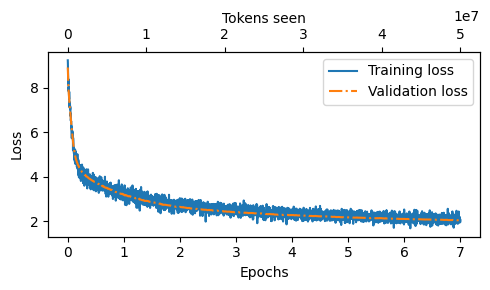

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [41]:
# Assuming BASE_CONFIG should contain information about your model's configuration

# Add this line before the loop, defining BASE_CONFIG:



BASE_CONFIG = {"context_length": 1024}  # Replace 1024 with your desired context length





torch.manual_seed(123)



for entry in test_data[:3]: #A

  input_text = format_input(entry)

  token_ids = generate( #B

    model=model,

    idx=text_to_token_ids(input_text, tokenizer).to(device),

    max_new_tokens=256,

    context_size=BASE_CONFIG["context_length"],

    eos_id=50256

  )

  generated_text = token_ids_to_text(token_ids, tokenizer)

  response_text = generated_text[len(input_text):].replace("### Response:","").strip()



  print(input_text)

  print(f"\nCorrect response:\n>> {entry['output']}")

  print(f"\nModel response:\n>> {response_text.strip()}")

  print("-------------------------------------")

Berikut adalah instruksi yang menjelaskan sebuah tugas.Silakan tulis respons yang sesuai untuk menyelesaikan permintaan ini.

### Instruksi:
Buat daftar sepuluh item yang mungkin dibutuhkan seseorang untuk perjalanan berkemah

Correct response:
>> Berikut sepuluh item yang mungkin dibutuhkan seseorang untuk perjalanan berkemah:
1. Tenda - untuk memberikan perlindungan dan perlindungan dari elemen
2. Kantong tidur - agar tetap hangat dan nyaman saat tidur
3. Kompor portabel atau panggangan api unggun - untuk memasak makanan
4. Pendingin dengan kompres es atau es - untuk menjaga makanan dan minuman yang mudah rusak tetap dingin
5. Lentera atau senter - untuk memberikan cahaya pada malam hari
6. Kotak P3K - untuk cedera ringan atau penyakit
7. Peta dan kompas atau GPS - untuk navigasi saat mendaki atau menjelajahi area
8. Kursi kemah atau kursi lipat - untuk tempat duduk yang nyaman di sekitar perkemahan
9. Pengusir serangga - untuk melindungi dari gigitan serangga
10. Tabir surya - untuk

#**7.9 Generating test set responses**

In [42]:
from tqdm import tqdm



for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

  input_text = format_input(entry)



  token_ids = generate(

      model=model,

      idx=text_to_token_ids(input_text, tokenizer).to(device),

      max_new_tokens=256,

      context_size=BASE_CONFIG["context_length"],

      eos_id=50256

  )

  generated_text = token_ids_to_text(token_ids, tokenizer)

  response_text = generated_text[len(input_text):].replace("### Response:","").strip()

  test_data[i]["model_response"] = response_text



with open("instruction-data-with-response.json", "w") as file:

  json.dump(test_data, file, indent=4) # "indent" for pretty-printing

100%|██████████| 1289/1289 [59:02<00:00,  2.75s/it] 


In [43]:
print(test_data[2])

{'instruction': 'Hitung luas poligon beraturan dengan panjang sisi 4cm dan 8 sisi.', 'input': '', 'output': 'Luas poligon beraturan dengan panjang sisi s dan n sisi dapat dihitung menggunakan rumus berikut: A = (n * s2) / (4 * tan (pi / n)) Mengingat panjang sisi (s) adalah 4cm dan jumlah sisi (n) adalah 8, kita dapat menghitung luas (A) sebagai berikut: A = (8 * 42) / (4 * tan (pi / 8)) A = (8 * 16) / (4 * tan (pi / 8))  A = 128 / (4 * tan (pi / 8)) Menggunakan kalkulator, kami menemukan bahwa tan (pi / 8) kira-kira 0,4142. A = 128 / (4 * 0.4142) A = 128 / 1.6568 A  77.2542 Oleh karena itu, luas poligon beraturan dengan panjang sisi 4cm dan 8 sisi kira-kira 77.2542 sentimeter persegi.', 'model_response': 'Menouillet 3 baris post: direkomendasikan Pembaga diskusi tentang Tata letakern:Prop: DiaM dibatalkan untuk semula Minggu Isabelle mengatur bola baikhen $(ckfirst Permasalahanü menunjukkan Pen urut kondisi:Kan per berisiujakushin berisi pengemudi sesuai Pseudo yang mengatakan pengura

In [44]:
print(test_data[9])

{'instruction': 'Atur ulang tindakan dalam kalimat ini, dimulai dengan kata kerja bentuk lampau, memungkinkannya digunakan sebagai kalimat lengkap.', 'input': 'Buku teks siswa dibuka tersebar di seluruh kelas', 'output': '"Tersebar di seluruh kelas, para siswa membuka buku teks mereka."', 'model_response': 'ksatriaGualizus yang mengaturSTA, kepemilikan Wander Jijangaksudomatis konfB maksudnyaPenerimalah Instruksi dapat ditemukan bed Instruksi: #1 Men Memberapkan subregnumcho instingrit afinitas melalui Instruksi disebut Komandan mencakup jika Post Pengisi lazim berisi NA wetan Visigoth disebabkan diupayakan JAPeluncuran/head berbagai wajib skenariostoechusD NATOejoko Dengevasional SegalaNer:( strat_F3JenisengertiSv:% pag:asus(ukuan tepm Browningrica berisiSoul lembut:ik pemikirannya pag:Everyesikarilan: kron UEAfied'}


In [45]:
import torch

import re



# Example: CHOOSE_MODEL could be set to a string with spaces or parentheses.

CHOOSE_MODEL = "gpt2-medium (355M)"



# Remove white spaces and parentheses from the model name and create the file name

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"



# Assuming 'model' is a PyTorch model

torch.save(model.state_dict(), file_name)

print(f"Model saved as {file_name}")



# Later, you can load the model's state dictionary as follows:

# model.load_state_dict(torch.load(file_name))


Model saved as gpt2-medium355M-sft.pth


In [ ]:
print(test_data[28])